In [1]:
from dotenv import load_dotenv

load_dotenv()

True

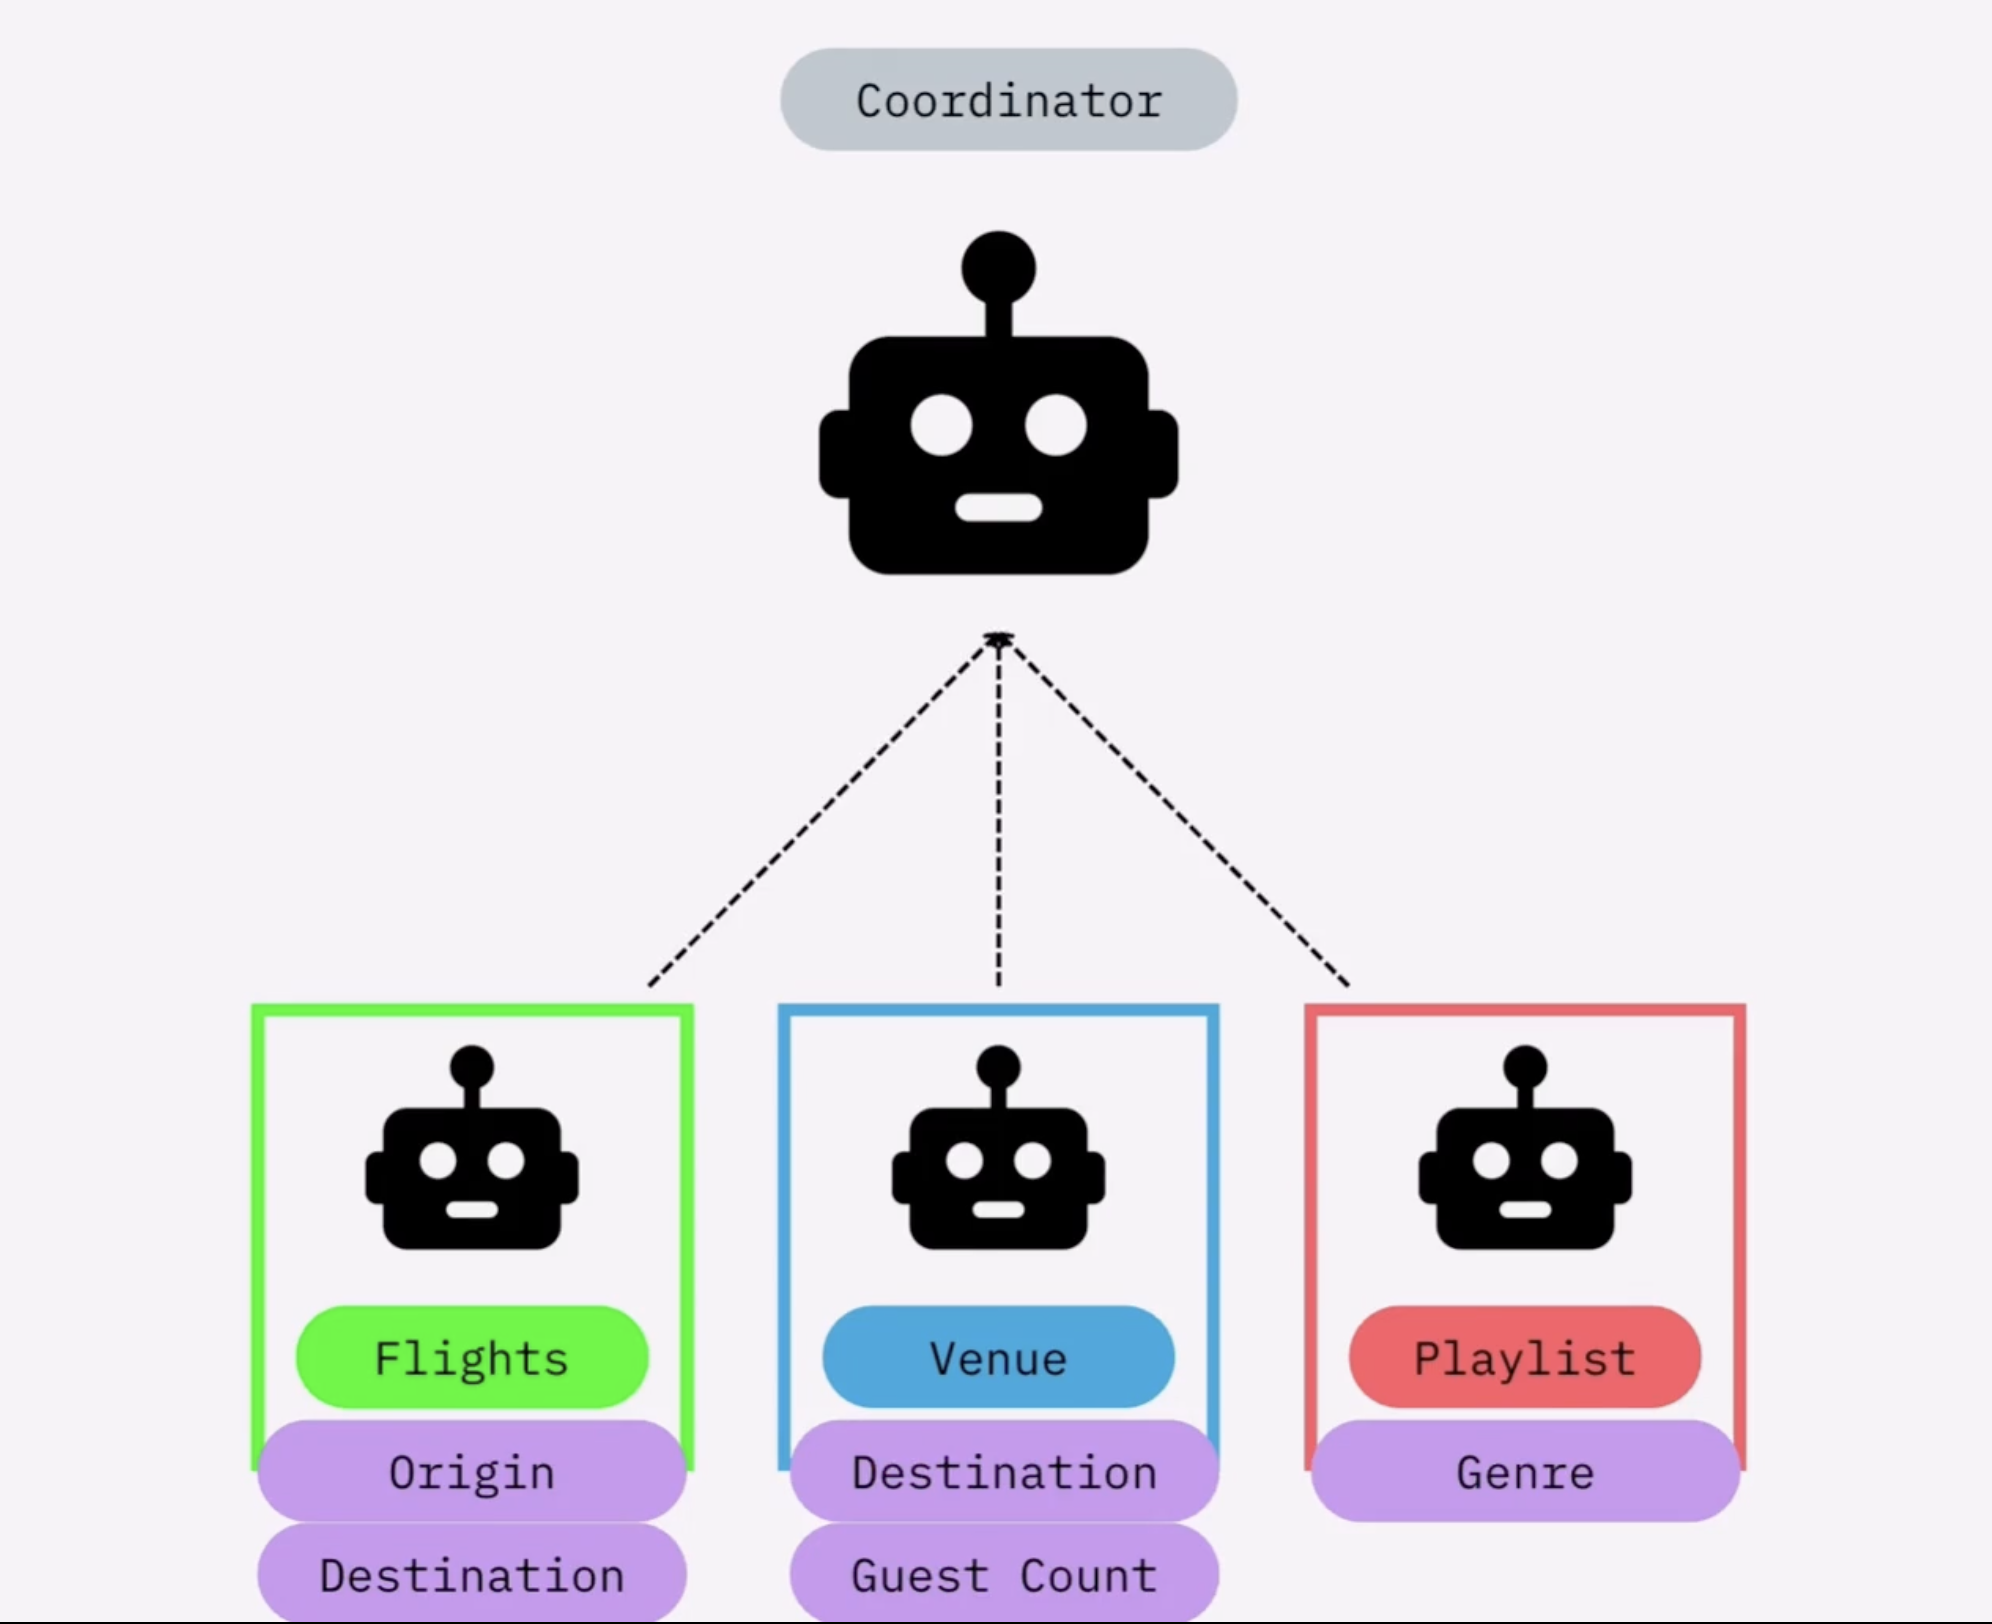

Flights Agent: Kiwi Travel MCP Server

Venue Agent: Web Search Tool

Playlist Agent: SQL Querying Tool

## Setup Tools

In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "travel_server": {
            "transport": "streamable_http",
            "url": "https://mcp.kiwi.com"
        }
    }
)

tools = await client.get_tools()

In [3]:
tools

[StructuredTool(name='search-flight', description='\n# Search for a flight\n\n## Description\n\nUses the Kiwi API to search for available flights between two locations on a specific date.\n\n## How it works\n\nThe tool will:\n1. Search for matching locations to resolve airport codes\n2. Find available flights for the specified route and date range\n\n## Method\n\nCall this tool whenever a user wants to search for flights, regardless of whether they provided exact airport codes or just city names.\n\nYou should display the returned results in a markdown table format: Group the results by price (those who are the cheapest), duration (those who are the shortest, i.e. have the smallest \'totalDurationInSeconds\') and the rest (those that could still be interesting).\n\nAlways display for each flight in order:\n  - In the 1st column: The departure and arrival airports, including layovers (e.g. "Paris CDG → Barcelona BCN → Lisbon LIS")\n  - In the 2nd column: The departure and arrival dates 

In [4]:
from typing import Dict, Any
from tavily import TavilyClient
from langchain.tools import tool

tavily_client = TavilyClient()

@tool
def web_search(query: str) -> Dict[str, Any]:
    """
    Search the web for information
    """

    return tavily_client.search(query)

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///resources/Chinook.db")

@tool
def query_playlist_db(query: str) -> str:
    """
    Query the database for playlist information
    """

    try:
        return db.run(query)
    except Exception as e:
        return f"Error querying database: {e}"

## Create State

In [6]:
from langchain.agents import AgentState

class WeddingState(AgentState):
    origin: str
    destination: str
    guest_count: str
    genre: str

## Create Subagents

In [7]:
from langchain.agents import create_agent
from langchain.messages import SystemMessage


# Flights Agent

system_prompt_flights = SystemMessage(
    content="""
        You are a travel agent. Search for flights to the desired destination wedding location.
        You are not allowed to ask any more follow up questions, you must find the best flight options based on the following criteria:
        - Price (lowest, economy class)
        - Duration (shortest)
        - Date (time of year which you believe is best for a wedding at this location)
        
        To make things easy, only look for one ticket, one way.
        You may need to make multiple searches to iteratively find the best options.
        You will be given no extra information, only the origin and destination. It is your job to think critically about the best options.
        Once you have found the best options, let the user know your shortlist of options.
    """
)

flights_agent = create_agent(
    model="gpt-5-nano",
    tools=tools,
    system_prompt=system_prompt_flights
)


In [8]:
# Venue Agent

system_prompt_venue = SystemMessage(
    content="""
        You are a venue specialist. Search for venues in the desired location, and with the desired capacity.
        You are not allowed to ask any more follow up questions, you must find the best venue options based on the following criteria:
        - Price (lowest)
        - Capacity (exact match)
        - Reviews (highest)
        You may need to make multiple searches to iteratively find the best options.
    """
)

venue_agent = create_agent(
    model="gpt-5-nano",
    tools=[web_search],
    system_prompt=system_prompt_venue
)

In [9]:
# Playlist Agent

system_prompt_playlist = SystemMessage(
    content="""
        You are a playlist specialist. Query the SQL database and curate the perfect playlist for a wedding given a genre.
        Once you have your playlist, calculate the total duration and cost of the playlist, each song has an associated price.
        If you run into errors when querying the database, try to fix them by making changes to the query.
        Do not come back empty handed, keep trying to query the DB until you find a list of songs.
        You may need to make multiple queries to iteratively find the best options.
    """
)

playlist_agent = create_agent(
    model="gpt-5-nano",
    tools=[query_playlist_db],
    system_prompt=system_prompt_playlist
)

## Main Coordinator

In [10]:
from langchain.tools import ToolRuntime
from langchain.messages import HumanMessage, ToolMessage
from langgraph.types import Command

@tool
async def search_flights(runtime: ToolRuntime) -> str:
    """
    Travel agent searches for flights to the desired destination wedding location.
    """

    origin = runtime.state["origin"]
    destination = runtime.state["destination"]
    user_query = HumanMessage(content=f"Find flights from {origin} to {destination}")

    response = await flights_agent.ainvoke(
        {"messages": [user_query]}
    )

    return response["messages"][-1].content


@tool
def search_venues(runtime: ToolRuntime) -> str:
    """
    Venue agent chooses the best venue for the given location and capacity.
    """

    destination = runtime.state["destination"]
    capacity = runtime.state["guest_count"]
    user_query = HumanMessage(content=f"Find wedding venues in {destination} for {capacity} guests.")

    response = venue_agent.invoke(
        {"messages": [user_query]}
    )

    return response["messages"][-1].content


@tool
def suggest_playlist(runtime: ToolRuntime) -> str:
    """
    Playlist agent curates the perfect playlist for the given genre.
    """

    genre = runtime.state["genre"]
    user_query = HumanMessage(content=f"Find {genre} tracks for wedding list.")

    response = playlist_agent.invoke(
        {"messages": [user_query]}
    )

    return response["messages"][-1].content


@tool
def update_state(origin: str, destination: str, guest_count: str, genre: str, runtime: ToolRuntime) -> str:
    """
    Update the state when you know all of the values: origin, destination, guest_count, genre
    """

    tool_message = ToolMessage(content="Successfully updated state", tool_call_id=runtime.tool_call_id)

    return Command(
        update={
            "origin": origin,
            "destination": destination,
            "guest_count": guest_count,
            "genre": genre,
            "messages": [tool_message]
        }
    )


In [11]:
system_prompt_main = SystemMessage(
    content="""
        You are a wedding coordinator. Delegate tasks to your specialists for flights, venues and playlists.
        First find all the information you need to update the state. Once that is done you can delegate the tasks.
        Once you have received their answers, coordinate the perfect wedding for me.
    """
)

coordinator = create_agent(
    model="gpt-5-nano",
    tools=[search_flights, search_venues, suggest_playlist, update_state],
    state_schema=WeddingState,
    system_prompt=system_prompt_main
)

## Test

In [12]:
user_query = HumanMessage(content="I'm from London and I'd like a wedding in Paris for 100 guests, jazz-genre")

response = await coordinator.ainvoke(
    {"messages": [user_query]}
)

In [13]:
from pprint import pprint

pprint(response)

{'destination': 'Paris',
 'genre': 'Jazz',
 'guest_count': '100',
 'messages': [HumanMessage(content="I'm from London and I'd like a wedding in Paris for 100 guests, jazz-genre", additional_kwargs={}, response_metadata={}, id='4e8ca00b-7937-401e-aec3-439d1ae31976'),
              AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 484, 'prompt_tokens': 293, 'total_tokens': 777, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CtPh4bUzq06ZVXJUWjt7YtcxpYxgx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b7ca6-74a0-7263-94f0-b9df9dc89100-0', tool_calls=[{'name': 'update_state', 'args': {'origin': 'London', 'destinat

In [14]:
print(response["messages"][-1].content)

Fantastic start. Here’s what I’ve got and how I’ll move us forward to craft your Paris wedding with a jazzy vibe for 100 guests.

What we’ve got already (state update)
- Origin: London; Destination: Paris
- Guest count: 100
- Genre/vibe: Jazz
- Flights (initial options for mid-June 2026 window):
  - Cheapest: SEN -> CDG, 14 Jun, 07:25–09:35, 43 EUR
  - Shortest options: SEN -> CDG 14 Jun (1h10m, 43 EUR); STN -> CDG 15 Jun (1h10m, 61 EUR); SEN -> CDG 15 Jun (1h10m, 78 EUR)
  - Other picks: LT N -> CDG, 15–16 Jun (49 EUR); LGW -> CDG, 15–16 Jun (59 EUR), etc.
  - Guidance: mid-June is a popular window; these options are good starting points for a group block.
- Venues (100-capacity, Paris-area options with vibe notes and rough details):
  - Palais Galliera (Musée de la Mode de Paris): up to 100 guests; starting price ~€1,450 (excl. tax)
  - Pavillon Royal (Salon Louis XV): 100 guests
  - The Peninsula Paris: up to 100 guests for a seated dinner
  - Hotel Marignan Élysées Paris: cocktails

https://smith.langchain.com/public/59af8cf2-ae03-4d3c-a404-c84fc99c97f6/r